<h1><center><font size='25'>Predicción del precio de Bitcoin con Python, cuando el pasado no se repite</font></center></h1>

<center><b>Javier Escobar Ortiz</b></center>

<center><i>Febrero, 2022</i></center>

Más sobre ciencia de datos: [**cienciadedatos.net**](https://cienciadedatos.net)

+ [Skforecast: forecasting series temporales con Python y Scikit Learn](https://www.cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html)
+ [Predicción (forecasting) de la demanda eléctrica con Python](https://www.cienciadedatos.net/documentos/py29-forecasting-demanda-energia-electrica-python.html)
+ [Predicción (forecasting) de visitas a página web con machine learning](https://www.cienciadedatos.net/documentos/py37-forecasting-visitas-web-machine-learning.html)
+ [Forecasting series temporales con gradient boosting: Skforecast, XGBoost, LightGBM y CatBoost](https://www.cienciadedatos.net/documentos/py39-forecasting-series-temporales-con-skforecast-xgboost-lightgbm-catboost.html)

## Introducción
<br>

Una serie temporal (*time series*) es una sucesión de datos ordenados cronológicamente y espaciados a intervalos iguales o desiguales. El proceso de *forecasting* consiste en predecir el valor futuro de una serie temporal, bien modelando la serie únicamente en función de su comportamiento pasado (autorregresivo) o empleando otras variables externas. Aunque se pueda aplicar esta metodología, existen determinadas series temporales en las que su valor pasado no asegura el valor futuro. Realizar un buen estudio de la variable y saber reconocer la ausencia de autocorrelación (el problema se encuentra en los datos, no en el modelo) puede ahorrar tiempo de trabajo.

En este documento se muestra un ejemplo de cómo identificar situaciones en las que el proceso de *forecasting autorregresivo* no devuelve resultados útiles y, para ello, se intenta predecir el precio de cierre diario del Bitcoin utlizando métodos de *machine learning*. Se hace uso de [**Skforecast v0.4.2**](https://joaquinamatrodrigo.github.io/skforecast/0.4.2/index.html), una sencilla librería de Python que permite, entre otras cosas, adaptar cualquier regresor de **Scikit-learn** a problemas de *forecasting*.
<br>

## Caso de uso
<br>

<img src='./images/btc.png' style='width: 100px; padding-right: 15px;  padding-top: 5px' align='left'>

[Bitcoin](https://es.wikipedia.org/wiki/Bitcoin) (₿) es una moneda digital descentralizada, sin banco central ni administrador único, que puede enviarse de un usuario a otro mediante la red bitcoin peer-to-peer sin necesidad de intermediarios. Las transacciones son verificadas por los nodos de la red mediante criptografía y registradas en un libro de contabilidad público distribuido llamado *blockchain*. La criptomoneda fue inventada en 2008 por una persona o grupo de personas desconocidas con el nombre de Satoshi Nakamoto. Los Bitcoins se crean como recompensa por un proceso conocido como [minería](https://es.wikipedia.org/wiki/Miner%C3%ADa_de_bitcoin) y pueden intercambiarse por otras monedas, productos y servicios. Existen diversas opiniones sobre el Bitcoin, algunas personas lo ven como un activo especulativo de alto riesgo y otras como una reserva de valor.

Se pretende generar un modelo de *forecasting* capaz de predecir el precio del Bitcoin. Se dispone de una serie temporal con los precios de apertura (*Open*), cierre (*Close*), máximo (*High*) y mínimo (*Low*) del Bitcoin en dólares estadounidenses (USD) desde el 2013-04-28 al 2022-01-01. 
<br><br>

## Librerias

In [50]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import datetime
from cryptocmd import CmcScraper
from tqdm import tqdm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy import stats
plt.style.use('ggplot')

# Modelado y Forecasting
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

# # Configuración warnings
# # ==============================================================================
# import warnings
# warnings.filterwarnings('once')

## Datos
<br>

La descarga de datos se realiza mediante [cryptocmd](https://openbase.com/python/cryptocmd). Esta librería es útil para descargar datos históricos de criptomonedas de la página [Coinmarketcap](https://coinmarketcap.com/).

In [2]:
# Descarga de datos
# ==============================================================================

# Se inicializa el Scraper, se incluye simbolo, inicio y fin de la descarga
scraper = CmcScraper('BTC', '28-04-2013', '01-01-2022')

# Transformar datos recogidos en un dataframe
data_raw = scraper.get_dataframe()
data_raw.sort_values(by='Date', ascending=True, inplace=True)

pd.set_option('display.max_columns', None)
display(data_raw)
pd.reset_option('display.max_columns')

Date          Open          High           Low         Close  \
3170 2013-04-28    135.300003    135.979996    132.100006    134.210007   
3169 2013-04-29    134.444000    147.488007    134.000000    144.539993   
3168 2013-04-30    144.000000    146.929993    134.050003    139.000000   
3167 2013-05-01    139.000000    139.889999    107.720001    116.989998   
3166 2013-05-02    116.379997    125.599998     92.281898    105.209999   
...         ...           ...           ...           ...           ...   
4    2021-12-28  50679.859377  50679.859377  47414.209925  47588.854777   
3    2021-12-29  47623.870463  48119.740950  46201.494371  46444.710491   
2    2021-12-30  46490.606049  47879.965500  46060.313166  47178.125843   
1    2021-12-31  47169.372859  48472.527490  45819.954553  46306.446123   
0    2022-01-01  46311.744663  47827.310995  46288.486095  47686.811509   

            Volume    Market Cap  
3170  0.000000e+00  1.488567e+09  
3169  0.000000e+00  1.603769e+09  
3168  0.000000e+00  1.542813e+09  
3167  0.000000e+00  1.298955e+09  
3166  0.000000e+00  1.168517e+09  
...            ...           ...  
4     3.343038e+10  9.000762e+11  
3     3.004923e+10  8.784788e+11  
2     2.668649e+10  8.923863e+11  
1     3.697417e+10  8.759394e+11  
0     2.458267e+10  9.021042e+11  

[3171 rows x 7 columns]

In [3]:
# Preparación del dato
# ==============================================================================
data = data_raw.copy()
data['date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')
data = data[['date', 'Open', 'Close', 'High', 'Low']]
data.rename({'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, 
            axis=1, inplace=True)
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()

Uno de los primeros análisis que hay que realizar al trabajar con series temporales es verificar si la serie está completa.

In [4]:
# Verificar que un índice temporal está completo
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                              end=data.index.max(),
                              freq=data.index.freq)).all()

True

In [5]:
print(f'Número de filas con missing values: {data.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


### Distribución de los datos
<br>

Se muestra la distribución del precio de cierre del Bitcoin:

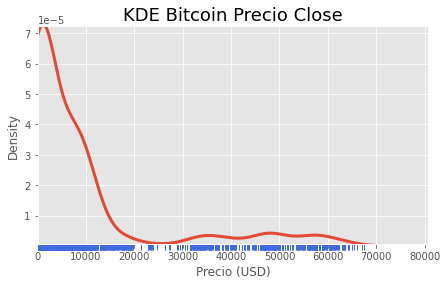

In [6]:
# Distribución KDE del precio de cierre del Bitcoin
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 4))
p = sns.kdeplot(data=data, x='close', linewidth=3, ax=ax)
r = sns.rugplot(data=data, x='close', ax=ax, c='royalblue',
                height=-.03, clip_on=False)
p.set(xlim=(0, None))
p.set_title('KDE Bitcoin Precio Close', fontsize=18)
p.set_xlabel('Precio (USD)');

En los datos de estudio se ve una distribución mayoritaria con el precio localizado por debajo de los 20.000 (USD), esta etapa corresponde al periodo entre el 2013 y septiembre de 2020. En cambio, desde 2021, el precio ha sufrido mayores cambios variando en este periodo en la zona de los 35.000 - 67.500 (USD).

Dado que nos encontramos con una **variable muy volátil** y con diferentes rangos de operación, una posibilidad es reducir el problema a un estudio de **deltas de cambio de precio**. Esto se podría simplificar aún más llevándolo al punto de simplemente indicar si el precio aumenta o disminuye respecto al día anterior.

*Nota: para este caso los deltas se han calculado como la diferencia entre los precios open y close.*

In [7]:
# Crear columna % cambio en el dia
# ==============================================================================
data['change_pct'] = data.pct_change(axis='columns').iloc[:, 1]*100
data.head(2)

open       close        high         low  change_pct
date                                                                  
2013-04-28  135.300003  134.210007  135.979996  132.100006   -0.805614
2013-04-29  134.444000  144.539993  147.488007  134.000000    7.509441

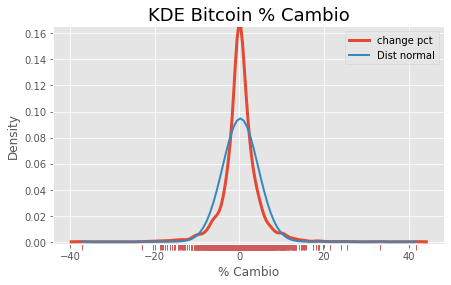

In [8]:
# Distribución normal
# ==============================================================================
# Valores de la media (mu) y desviación típica (sigma) de los datos
mu, sigma = stats.norm.fit(data.change_pct)

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(data.change_pct), max(data.change_pct), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Distribución KDE del % de cambio del Bitcoin
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 4))
p = sns.kdeplot(data=data, x='change_pct', linewidth=3, ax=ax, label='change pct')
r = sns.rugplot(data=data, x='change_pct', ax=ax, c='indianred',
                height=-.03, clip_on=False)
ax.plot(x_hat, y_hat, linewidth=2, label='Dist normal')
p.set_title('KDE Bitcoin % Cambio', fontsize=18)
ax.legend()
p.set_xlabel('% Cambio');

La nueva variable `change_pct` presenta una distribución simétrica. Con este método se consigue evitar el problema que presentan ciertos algoritmos de *machine learning*, como los basados en árboles de decisión, de no ser capaces de predecir fuera del rango de entrenamiento (extrapolar).

### Halving del Bitcoin como varible exógena
<br>

El Halving se trata de un evento programado y que forma parte del diseño y funcionamiento de algunas criptomonedas. Los mineros se dedican a validar los bloques de transacciones de la red, en este caso Bitcoin, y, cada vez que lo logran, reciben como recompensa una cantidad de esa moneda digital. Esta cantidad es fija pero sólo durante un tiempo.

En la *blockchain* de Bitcoin, cada vez que se añaden 210.000 bloques ocurre el cambio de recompensa. Este hecho, denominado como *halving*, se produce aproximadamente cada 4 años y reduce a la mitad las monedas que reciben los mineros como recompensa.

En la historia de Bitcoin han existido 3 *halvings*. Cuando se lanzó la minería de Bitcoin, los mineros recibían 50 BTC al extraer con éxito un bloque. En 2012 esta recompensa se redujo a 25 BTC, en 2016 bajó a 12,5 BTC, y en 2020 a 6,25 BTC, después del tercer halving. Por lo general, cada halving ha tenido un impacto en el precio aunque no necesariamente ha sido en el corto plazo.

Se pretende utilizar los días restantes para el próximo *halving* y sus recompensas de minado como **variables exógenas** para predecir el precio del Bitcoin. Se calcula que el próximo *halving* ocurrirá aproximadamente en 2024 aunque se desconoce su fecha exacta. Para estimarla, se toman los bloques restantes a fecha de 14/01/2022 de la página web [Coinmarketcap](https://coinmarketcap.com/es/halving/bitcoin/), 121.400, y se utiliza el promedio de los bloques de la red Bitcoin minados por día, 144 ([tiempo de bloque promedio](https://es.wikipedia.org/wiki/Bitcoin) $\approx$ 10 minutos).

*Nota: Al introducir una predicción como variable exógena en el modelo de forecasting, se estará introduciendo, dado que se trata de predicciones, su error en el modelo.*
<br>

In [9]:
# Dict con la info de los halvings del Bitcoin
# ==============================================================================
btc_halving = {'halving'              : [0, 1 , 2, 3, 4],
               'date'                 : ['2009-01-03', '2012-11-28', 
                                         '2016-07-09', '2020-05-11', np.nan],
               'reward'               : [50, 25, 12.5, 6.25, 3.125],
               'halving_block_number' : [0, 210000, 420000 ,630000, 840000]
              }

In [10]:
# Cálculo siguiente halving
# Se toma como base de partida los bloques restantes según la web 
# coinmarketcap.com para el próximo halving a fecha de 14/01/2022
# ==============================================================================
bloques_restantes = 121400
bloques_por_dia = 144

dias = bloques_restantes / bloques_por_dia

next_halving = pd.to_datetime('2022-01-14', format='%Y-%m-%d') + datetime.timedelta(days=dias)
next_halving = next_halving.replace(microsecond=0, second=0, minute=0, hour=0)
next_halving = next_halving.strftime('%Y-%m-%d')

btc_halving['date'][-1] = next_halving

print(f'EL próximo halving ocurrirá aproximadamente el: {next_halving}')

EL próximo halving ocurrirá aproximadamente el: 2024-05-06


In [11]:
# Incluir recompensas y cuenta regresiva para próximo halving en el dataset
# ==============================================================================
data['reward'] = np.nan
data['countdown_halving'] = np.nan
data['day'] = pd.to_datetime(data.index.date, format='%Y-%m-%d')

for i in range(len(btc_halving['halving'])-1):
    
    # Fecha inicial y final de cada halving
    start_date = pd.to_datetime(btc_halving['date'][i], format='%Y-%m-%d %H:%M:%S')
    end_date = pd.to_datetime(btc_halving['date'][i+1], format='%Y-%m-%d %H:%M:%S')
    mask = (data.index >= start_date) & (data.index < end_date)
    
    # Rellenar columna 'reward' con las recompensas de minería
    data.loc[mask, 'reward'] = btc_halving['reward'][i]
    
    # Rellenar columna 'countdown_halving' con los días restantes
    delta = end_date - start_date
    days = [day+1 for day in range(delta.days)][::-1]
    
    i = pd.date_range(start_date, periods=delta.days, freq='D')
    df_aux = pd.DataFrame({'countdown_aux':days}, index=i)
    
    data = data.merge(df_aux, how='left', left_on='day', right_index=True)
    data['countdown_halving'].fillna(data['countdown_aux'], inplace=True)
    data.drop(['countdown_aux'], axis=1, inplace=True)
    
data.drop(['day'], axis=1, inplace=True)

In [12]:
# Comprobar que se han creado los datos correctamente
# ==============================================================================
print('Segundo halving:', btc_halving['date'][2])
display(data.loc['2016-07-08':'2016-07-09'])
print('')
print('Tercer halving:', btc_halving['date'][3])
display(data.loc['2020-05-10':'2020-05-11'])
print('')
print('Próximo halving:', btc_halving['date'][4])
data.tail(2)

Segundo halving: 2016-07-09


open       close        high         low  change_pct  \
date                                                                     
2016-07-08  640.687988  666.523010  666.706970  636.466980    4.032387   
2016-07-09  666.383972  650.960022  666.383972  633.398987   -2.314574   

            reward  countdown_halving  
date                                   
2016-07-08    25.0                1.0  
2016-07-09    12.5             1402.0


Tercer halving: 2020-05-11


open        close         high          low  change_pct  \
date                                                                         
2020-05-10  9591.169231  8756.431142  9595.580629  8395.107451   -8.703194   
2020-05-11  8755.535639  8601.796202  9033.471176  8374.322975   -1.755911   

            reward  countdown_halving  
date                                   
2020-05-10   12.50                1.0  
2020-05-11    6.25             1456.0


Próximo halving: 2024-05-06


open         close          high           low  \
date                                                                 
2021-12-31  47169.372859  46306.446123  48472.527490  45819.954553   
2022-01-01  46311.744663  47686.811509  47827.310995  46288.486095   

            change_pct  reward  countdown_halving  
date                                               
2021-12-31   -1.829422    6.25              857.0  
2022-01-01    2.969154    6.25              856.0

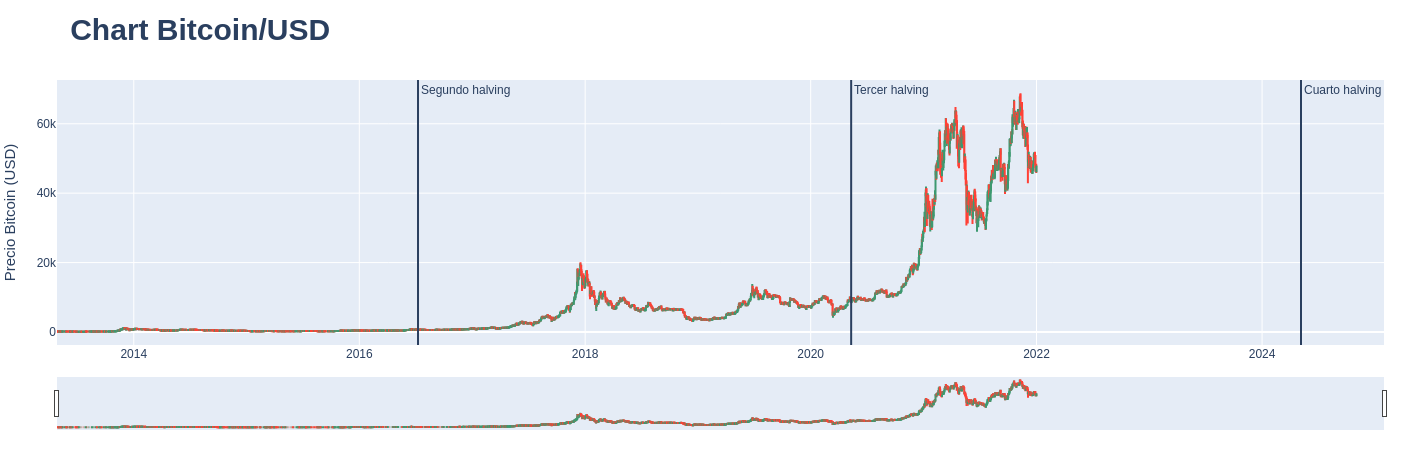

In [13]:
# Gráfico de velas japonesas interactivo
# ==============================================================================
candlestick = go.Candlestick(
                            x = data.index,
                            open = data.open,
                            close = data.close,
                            low = data.low,
                            high = data.high,
                            )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 900,
    height      = 450,
    title       = dict(text='<b>Chart Bitcoin/USD</b>', font=dict(size=30)),
    yaxis_title = dict(text='Precio Bitcoin (USD)', font=dict(size=15)),
    margin      = dict(l=10, r=20, t=80, b=20),
    shapes      = [dict(x0=btc_halving['date'][2], x1=btc_halving['date'][2], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][3], x1=btc_halving['date'][3], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][4], x1=btc_halving['date'][4], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2)
                  ],
    annotations = [dict(x=btc_halving['date'][2], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Segundo halving'),
                   dict(x=btc_halving['date'][3], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Tercer halving'),
                   dict(x=btc_halving['date'][4], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Cuarto halving')
                  ],
)

fig.update_xaxes(
    rangeslider_visible=True,
)

fig.show()

## Teoría del paseo aleatorio
<br>

Antes de comenzar con este estudio es importante destacar que la evolución de los precios de un activo, en este caso el Bitcoin, se clasifica como un [proceso estocástico](https://es.wikipedia.org/wiki/Proceso_estoc%C3%A1stico). Este se define como la evolución de una variable aleatoria en función de otra que, en el caso de series temporales, es el tiempo. Según la [teoría del paseo aleatorio](https://economipedia.com/definiciones/teoria-paseo-aleatorio.html), los precios de mercado se comportan de manera aleatoria y no dependiente de su serie temporal. De esta manera, la mejor estimación para el valor $t_{n+1}$ será el valor $t_{n}$ más un cambio impredecible. 

Esto se puede comprobar graficamente:

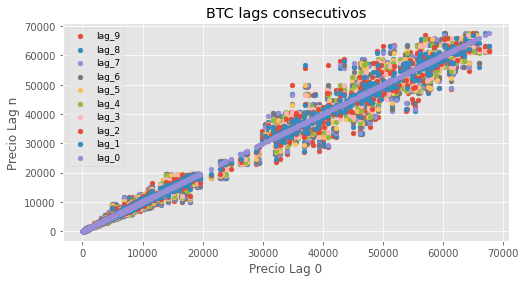

In [14]:
# Gráfico lags consecutivos
# ==============================================================================
df_plot = data[['close']].copy()
lags = 10
for i in range(lags):
    df_plot[f'lag_{i}'] = df_plot.close.shift(i)
    
fig, ax = plt.subplots(figsize=(8, 4))
for i in range(lags)[::-1]:   
    ax.scatter(df_plot['close'], df_plot[f'lag_{i}'], label=f'lag_{i}', s=23)

ax.set(xlabel='Precio Lag 0', ylabel='Precio Lag n',
       title='BTC lags consecutivos')
ax.legend(prop={'size': 9});

Según aumenta la distancia con respecto a la serie inicial (*lag 0*), la diferencia entre los precios, por lo general, es mayor. Esto se comprueba dado que a mayor lag existe más dispersión de los puntos respecto a la recta $x = y$.

Esto refleja la ausencia de carácter autorregresivo en la estimación y evolución de los valores de mercado.

## Exploración Gráfica

In [15]:
# Colores Bitcoin
# ==============================================================================
palette_btc = {'naranja': '#f7931a',
               'blanco' : '#ffffff',
               'gris' : '#4d4d4d',
               'azul' : '#0d579b',
               'verde' : '#329239'
              }

### Cambio de precio por año

In [16]:
# Se localizan los datos correspondientes para cada año
# ==============================================================================
years = list(data.index.year.unique())
df = pd.DataFrame()

for year in years:
    
    year_open  = data[data.index.year == year].loc[:, 'open'][0]
    year_close = data[data.index.year == year].loc[:, 'close'][-1]
    year_low  = data[data.index.year == year]['low'].min()
    year_high = data[data.index.year == year]['high'].max()
    
    df[year] = pd.Series([year_open, year_close, year_low, year_high]) 
    
df_plot = df.T
df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1, inplace=True)

# Se calcula el % de cambio entre el open y el close del año
# ==============================================================================
df_plot['change_pct'] = df.pct_change().iloc[-3,:]*100
df_plot.head(3)

open       close         low         high  change_pct
2013  135.300003  754.010010   65.526001  1156.140015  457.287504
2014  754.969971  320.192993  289.295990  1017.119995  -57.588645
2015  320.434998  430.566986  171.509995   495.562012   34.369526

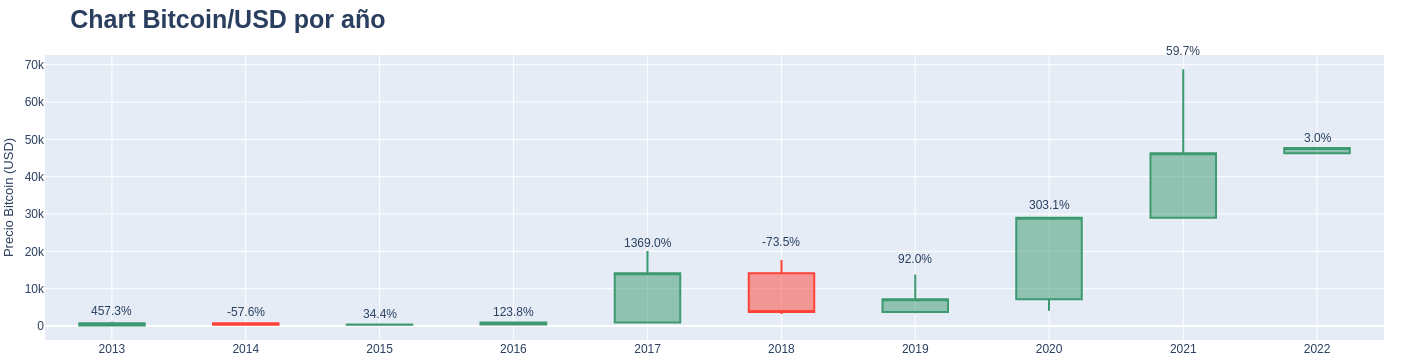

In [17]:
# Se crea una lista de dicts con las anotaciones de % de cambio para el gráfico
# ==============================================================================
annotations_list = []
max_high = df_plot['high'].max()

for year in years:
    
    df_aux = df_plot[df_plot.index == year]
    loc_x = pd.to_datetime(df_aux.index[0], format='%Y')
    loc_y = df_aux['high'].values[0]/max_high + 0.05
    text = '{:.1f}%'.format(df_aux['change_pct'].values[0])
    
    annotation = dict(x=loc_x, y=loc_y, 
                      xref='x', yref='paper',
                      showarrow=False, xanchor='center', 
                      text=text)

    annotations_list.append(annotation)

# Gráfico de velas japonesas anual interactivo
# ==============================================================================
candlestick = go.Candlestick(
                            x = pd.to_datetime(df_plot.index, format='%Y'),
                            open = df_plot.open,
                            close = df_plot.close,
                            low = df_plot.low,
                            high = df_plot.high
                            )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 800,
    height      = 350,
    title       = dict(text='<b>Chart Bitcoin/USD por año</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio Bitcoin (USD)', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20),
    xaxis_rangeslider_visible = False,
    annotations = annotations_list
    )

fig.show()

### Estacionalidad anual, mensual y semanal

In [18]:
# Se localizan los datos correspondientes para cada mes
# ==============================================================================
years = list(data.index.year.unique())
df = pd.DataFrame()

for year in years:
    for mes in range(12):
        
        start_date = pd.to_datetime(f'{year}-{mes+1}-01', format='%Y-%m-%d')
        end_date = (start_date + pd.offsets.MonthBegin())
        
        if not data[(data.index >= start_date) & (data.index < end_date)].empty:
        
            month_open  = data[(data.index >= start_date) 
                               & (data.index < end_date)].loc[:, 'open'][0]
            month_close = data[(data.index >= start_date) 
                               & (data.index < end_date)].loc[:, 'close'][-1]
            month_low  = data[(data.index >= start_date) 
                              & (data.index < end_date)]['low'].min()
            month_high = data[(data.index >= start_date) 
                              & (data.index < end_date)]['high'].max()
            
            serie = pd.Series([month_open, month_close, month_low, month_high])
            
            df_aux = pd.DataFrame(serie, columns=[f'{str(mes+1).zfill(2)}-{year}'])
            
            if df.empty:
                df = df_aux.copy()
            else:
                df = pd.concat([df, df_aux], axis=1)

df_plot = df.T
df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1, inplace=True)

# Se calcula el % de cambio entre el open y el close del mes-año
# ==============================================================================
df_plot['change_pct'] = df.pct_change().iloc[1,:]*100
df_plot.head(3)

open       close         low        high  change_pct
04-2013  135.300003  139.000000  132.100006  147.488007    2.734661
05-2013  139.000000  129.000000   79.099998  139.889999   -7.194245
06-2013  128.815002   96.613998   88.500000  129.779999  -24.997868

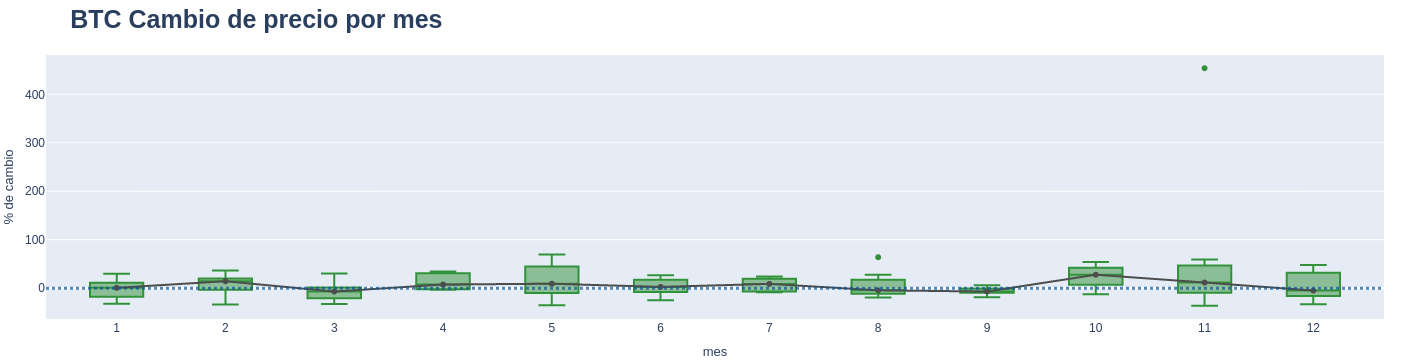

In [20]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
# df_plot['mes'] = pd.to_datetime(df_plot.index, format='%m-%Y').month
# fig, ax = plt.subplots(figsize=(7, 3.5))
# df_plot.boxplot(column='change_pct', by='mes', ax=ax,)
# df_plot.groupby('mes')['change_pct'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('% de cambio')
# ax.set_title('BTC Cambio de precio por mes')
# fig.suptitle('');

df_plot['mes'] = pd.to_datetime(df_plot.index, format='%m-%Y').month

# fig 1 boxplot de los meses
fig1 = px.box(df_plot.sort_values('mes'), x='mes', y='change_pct',
              color_discrete_sequence=[palette_btc['verde']])

# fig 2 line con datos de la mediana de cada mes
df_median = pd.DataFrame(df_plot.groupby('mes')['change_pct'].median()).reset_index()
fig2 = px.line(df_median, x='mes', y='change_pct', markers=True,
               color_discrete_sequence=[palette_btc['gris']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.add_shape(type='line', line_color=palette_btc['azul'], 
              line_width=3, opacity=0.7, line_dash='dot',
              x0=0, x1=1, xref='paper', y0=0, y1=0, yref='y'
             )

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>BTC Cambio de precio por mes</b>', font=dict(size=25)),
    yaxis_title = dict(text='% de cambio', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='mes', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
    )

fig.show()

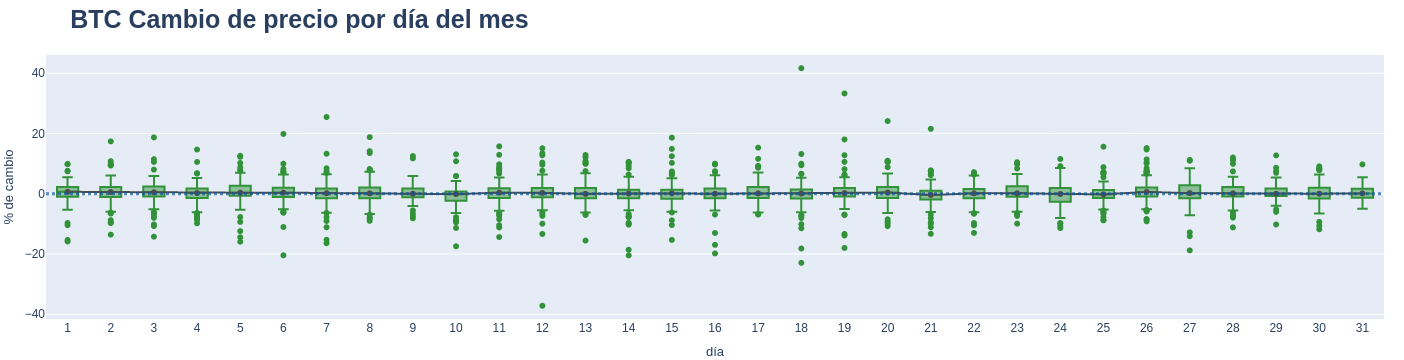

In [21]:
# Gráfico boxplot para estacionalidad mensual
# ==============================================================================
# fig, ax = plt.subplots(figsize=(9, 3.5))
# data['dia_mes'] = pd.Series(data.index).dt.day.values
# data['pct_change'] = data.change_pct(axis='columns').iloc[:, 3]*100
# data.boxplot(column='change_pct', by='dia_mes', ax=ax,)
# data.groupby('dia_mes')['change_pct'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('% de cambio')
# ax.set_title('BTC Cambio de precio por día del mes')
# fig.suptitle('');

data['dia_mes'] = pd.Series(data.index).dt.day.values

# fig 1 boxplot de los meses
fig1 = px.box(data.sort_values('dia_mes'), x='dia_mes', y='change_pct',
              color_discrete_sequence=[palette_btc['verde']])

# fig 2 line con datos de la mediana de cada mes
df_median = pd.DataFrame(data.groupby('dia_mes')['change_pct'].median()).reset_index()
fig2 = px.line(df_median, x='dia_mes', y='change_pct', markers=True,
               color_discrete_sequence=[palette_btc['gris']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.add_shape(type='line', line_color=palette_btc['azul'], 
              line_width=3, opacity=0.7, line_dash='dot',
              x0=0, x1=1, xref='paper', y0=0, y1=0, yref='y'
             )

fig.update_layout(
    width       = 750,
    height      = 350,
    title       = dict(text='<b>BTC Cambio de precio por día del mes</b>', font=dict(size=25)),
    yaxis_title = dict(text='% de cambio', font=dict(size=13)),
    xaxis       = dict(tickmode='linear', tickangle=0, range=[0.5, 31.5]),
    xaxis_title = dict(text='día', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
    )

fig.show()

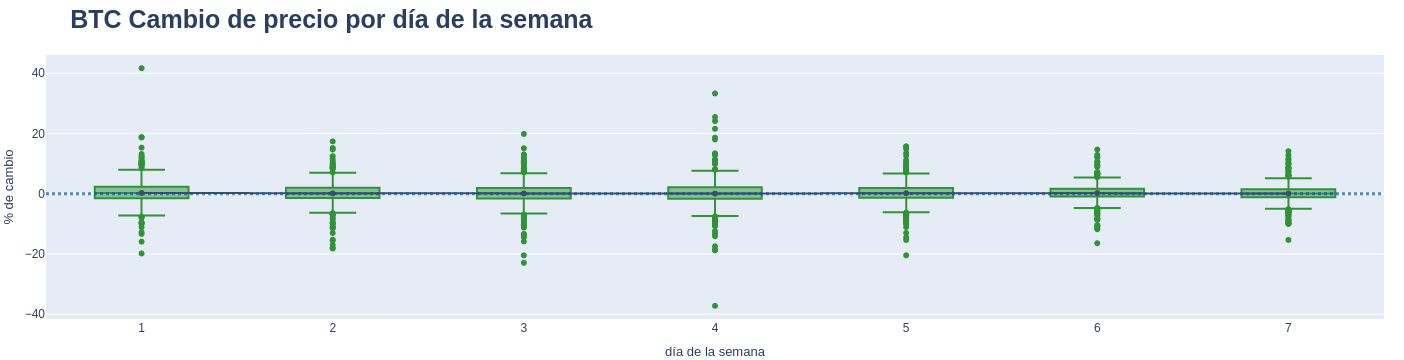

In [22]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
# fig, ax = plt.subplots(figsize=(7, 3.5))
# data['dia_semana'] = data.index.day_of_week + 1
# data.boxplot(column='change_pct', by='dia_semana', ax=ax)
# data.groupby('dia_semana')['change_pct'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('% de cambio')
# ax.set_title('BTC Cambio de precio por día de la semana')
# fig.suptitle('');

data['dia_semana'] = data.index.day_of_week + 1

# fig 1 boxplot de los meses
fig1 = px.box(data.sort_values('dia_semana'), x='dia_semana', y='change_pct',
              color_discrete_sequence=[palette_btc['verde']])

# fig 2 line con datos de la mediana de cada mes
df_median = pd.DataFrame(data.groupby('dia_semana')['change_pct'].median()).reset_index()
fig2 = px.line(df_median, x='dia_semana', y='change_pct', markers=True,
               color_discrete_sequence=[palette_btc['gris']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.add_shape(type='line', line_color=palette_btc['azul'], 
              line_width=3, opacity=0.7, line_dash='dot',
              x0=0, x1=1, xref='paper', y0=0, y1=0, yref='y'
             )

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>BTC Cambio de precio por día de la semana</b>', font=dict(size=25)),
    yaxis_title = dict(text='% de cambio', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='día de la semana', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
    )

fig.show()

Por lo general, una serie temporal con carácter autoreg

Respecto al Bitcoin, se puede apreciar una cierta estacionalidad anual en el porcentaje de cambio del precio, existen meses más volátiles como mayo o noviembre, y otros más estables como junio. En cambio, no aparece ningún tipo de estacionalidad en los datos mensual y semanal, se encuentra prácticamente centradas en todos sus valores.

### Gráficos de autocorrelación

#### Precio

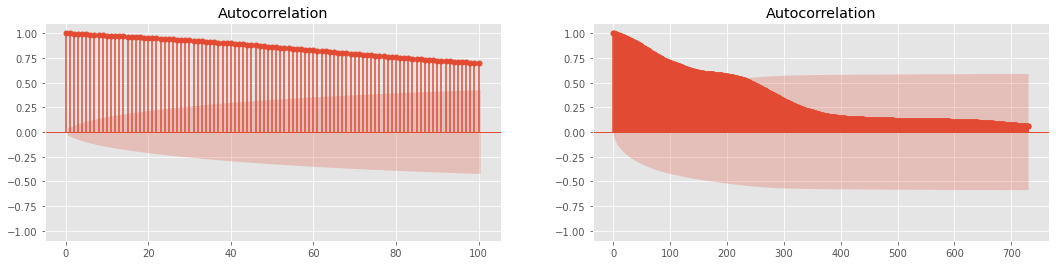

In [23]:
# Gráfico autocorrelación
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(data.close, ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(data.close, ax=axes[1], linewidth = 1, lags=730)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

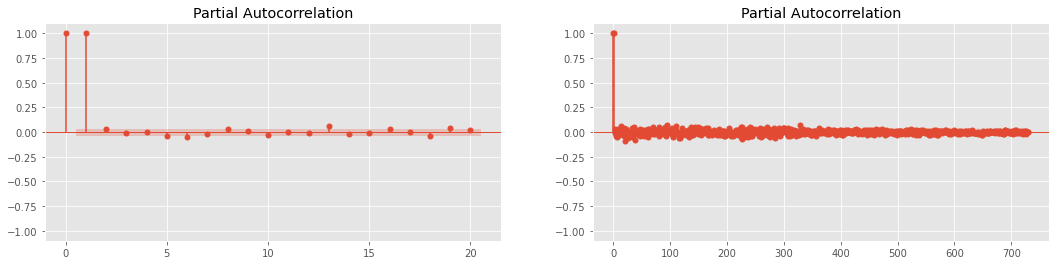

In [24]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_pacf(data.close, ax=axes[0], lags=20, method='ywm',  linewidth = 1)
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(data.close, ax=axes[1], lags=730, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

El gráfico de autocorrelación de la variable `close` comprueba lo explicado en la **teoría del paseo aleatorio**, el valor más parecido a $t_{n}$ es el $t_{n-1}$. De la misma manera, el gráfico de autocorrelación parcial indica que el *lag* 1 es el único que aporta información al *lag* 0 y que, después de este, todos los *lags* se encuentran dentro del umbral que amplica generación de ruido.

#### % de cambio en el día

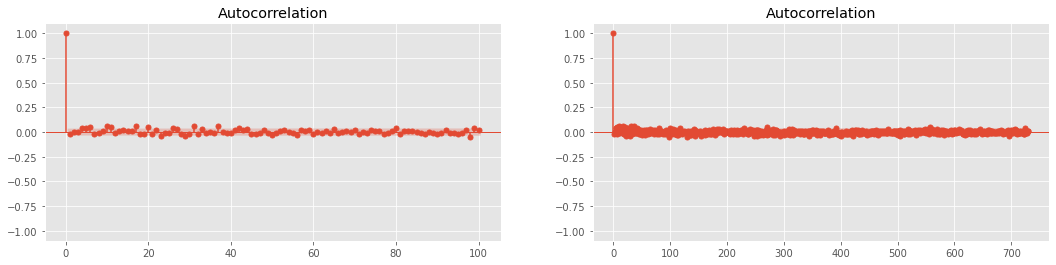

In [25]:
# Gráfico autocorrelación
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(data.change_pct, ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(data.change_pct, ax=axes[1], linewidth = 1, lags=730)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

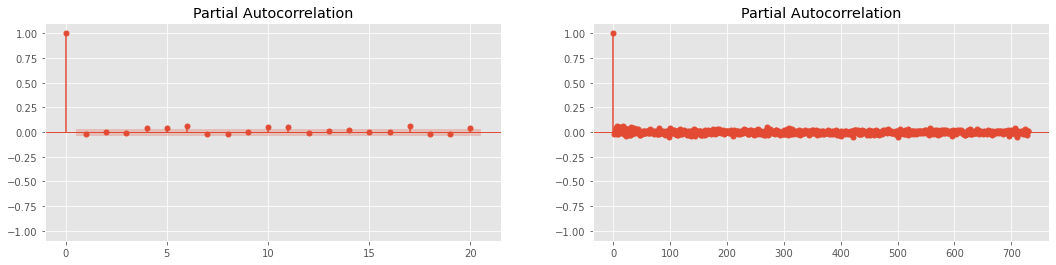

In [26]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_pacf(data.change_pct, ax=axes[0], lags=20, method='ywm',  linewidth = 1)
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(data.change_pct, ax=axes[1], lags=730, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

Repitiendo los mismos gráficos con el porcentaje de cambio en el día, `change_pct`, muestran ausencia de autocorrelación y autocorrelación parcial.

## Forecaster Autorregresivo
<br>

Aunque se dispone de una serie temporal amplia, esta presenta periodos con precios muy diferenciados como se ha podido determinar en la exploración gráfica. Se opta por utilizar solo el último año de datos para estudiar la capacidad autorregresiva del precio del Bitcoin. Se utiliza como modelo base un regresor [**LightGBM**](https://lightgbm.readthedocs.io/en/latest/), una nueva implementación del algoritmo [**XGBoost**](https://xgboost.readthedocs.io/en/stable/python/python_intro.html) desarrollada por Microsoft que también consigue excelentes resultados.

Pese a que con los estudios de autocorrelación y autocorrelación parcial ya se tienen indicios de la ausencia de capacidad autorregresiva, una estrategia para comprobar esto con la propia serie temporal es entrenar un modelo varias veces aplicando diferentes configuraciones de *lags* y calcular sus errores mediante [*backtesting*](https://joaquinamatrodrigo.github.io/skforecast/latest/guides/backtesting.html).

*Nota: Al trabajar con modelos basados en árboles de decisión no es extrictamente necesario realizar ningún tipo de preprocesado a los datos (`StandardScaler`, `MinMaxScaler`...).*

In [27]:
# Selección fechas train-test
# ==============================================================================
inicio_train = '2020-01-01 00:00:00'
fin_train = '2021-06-30 23:59:59'

print(f"Serie temporal completa : {data.index.min()} --- {data.index.max()}")
print(f"Fechas train            : {data.loc[inicio_train:fin_train].index.min()} --- {data.loc[inicio_train:fin_train].index.max()}")
print(f"Fechas test             : {data.loc[fin_train:].index.min()} --- {data.loc[fin_train:].index.max()}")

Serie temporal completa : 2013-04-28 00:00:00 --- 2022-01-01 00:00:00
Fechas train            : 2020-01-01 00:00:00 --- 2021-06-30 00:00:00
Fechas test             : 2021-07-01 00:00:00 --- 2022-01-01 00:00:00


In [46]:
# Función crear, entrenar y testear forecaster
# ==============================================================================
def producir_predicciones_forecaster(modelo, lags, variable):
    
    # Crear y entrenar forecaster
    forecaster = ForecasterAutoreg(
                    regressor = modelo,
                    lags      = lags
                 )

    forecaster.fit(y=data.loc[inicio_train:fin_train, variable])

    # Backtest training data
    metrica_train, predicciones_train = backtesting_forecaster(
                                            forecaster = forecaster,
                                            y          = data.loc[inicio_train:fin_train, variable],
                                            initial_train_size = None,
                                            steps      = 1,
                                            refit      = False,
                                            metric     = 'mean_squared_error',
                                            verbose    = False
                                        )    
    # Backtest test data, refit = False
    metrica_test, predicciones_test = backtesting_forecaster(
                                         forecaster = forecaster,
                                         y          = data.loc[inicio_train:, variable],
                                         initial_train_size = len(data.loc[inicio_train:fin_train, variable]),
                                         steps      = 7,
                                         refit      = False,
                                         metric     = 'mean_squared_error',
                                         verbose    = False
                                      )
    
    return metrica_train, metrica_test, predicciones_train, predicciones_test

lags  error_train   error_test   Exog
0                        1  1134.352886  3804.964664  False
1                        7   804.292828  4303.978072  False
2                       30   494.646312  4389.836613  False
3  [1, 2, 3, 7, 8, 30, 31]   783.383173  4267.720363  False

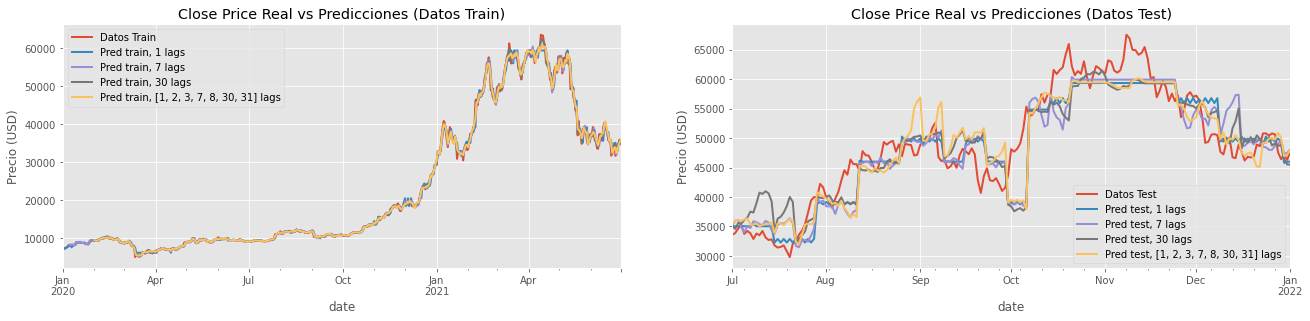

In [56]:
# Gráfico
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 4.5))
axes = axes.flat
data.loc[inicio_train:fin_train, 'close'].plot(ax=axes[0], linewidth=2, label='Datos Train')
data.loc[fin_train:, 'close'].plot(ax=axes[1], linewidth=2, label='Datos Test')

# Entrenar y plot modelo con diferentes lags
# ==============================================================================
lags = [1, 7, 30, [1, 2, 3, 7, 8, 30, 31]]
metricas_train = []
metricas_test = []

for lag in lags:
    
    metrica_train, metrica_test, predicciones_train, \
    predicciones_test = producir_predicciones_forecaster(
                            LGBMRegressor(random_state=123), 
                            lag, 'close'
                            )
    
    metricas_train.append(float(metrica_train**0.5))
    metricas_test.append(float(metrica_test**0.5))
    
    # Plot predicciones_train
    predicciones_train.rename(columns={'pred': f'Pred train, {lag} lags'}, inplace=True)
    predicciones_train.tail(len(data['close'])).plot(linewidth=2, ax=axes[0])
    
    # Plot predicciones_test
    predicciones_test.rename(columns={'pred': f'Pred test, {lag} lags'}, inplace=True)
    predicciones_test.plot(linewidth=2, ax=axes[1])

axes[0].set_title('Close Price Real vs Predicciones (Datos Train)')
axes[1].set_title('Close Price Real vs Predicciones (Datos Test)')
for ax in axes:
    ax.set_ylabel('Precio (USD)')
    ax.legend();
    
df_errores = pd.DataFrame({'lags': lags,
                           'error_train': metricas_train,
                           'error_test': metricas_test,
                           'Exog': False})
display(df_errores)

Representando los datos predichos se observa un alto grado de [*overfitting*](https://es.wikipedia.org/wiki/Sobreajuste) en la partición de entrenamiento provocando que, en los datos de test, el modelo no sea capaz de predecir los movimientos del precio.

Una situación que puede generar [*overfitting*](https://es.wikipedia.org/wiki/Sobreajuste) es el uso de un elevado número de predictores en la creación del modelo. Comparar el bias y la varianza en las predicciones según se va aumentando la complejidad del modelo (número de predictores en este caso) puede ayudar a identificar en que punto del [*Tradeoff* Bias-Varianza](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) se encuentra el modelo.

In [30]:
# Caclular metricas del modelo según aumenta el número de lags
# ==============================================================================
lags = [x+1 for x in range(100)]
metricas_train = []
stds_train = []
metricas_test = []
stds_test = []

for lag in tqdm(lags):
    metrica_train, metrica_test, predicciones_train \
    , predicciones_test = producir_predicciones_forecaster(
                            LGBMRegressor(random_state=123), 
                            lag, "close"
                            )
    
    metricas_train.append(float(metrica_train))
    metricas_test.append(float(metrica_test))
    stds_train.append(predicciones_train.pred.std())
    stds_test.append(predicciones_test.pred.std())

100%|█████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


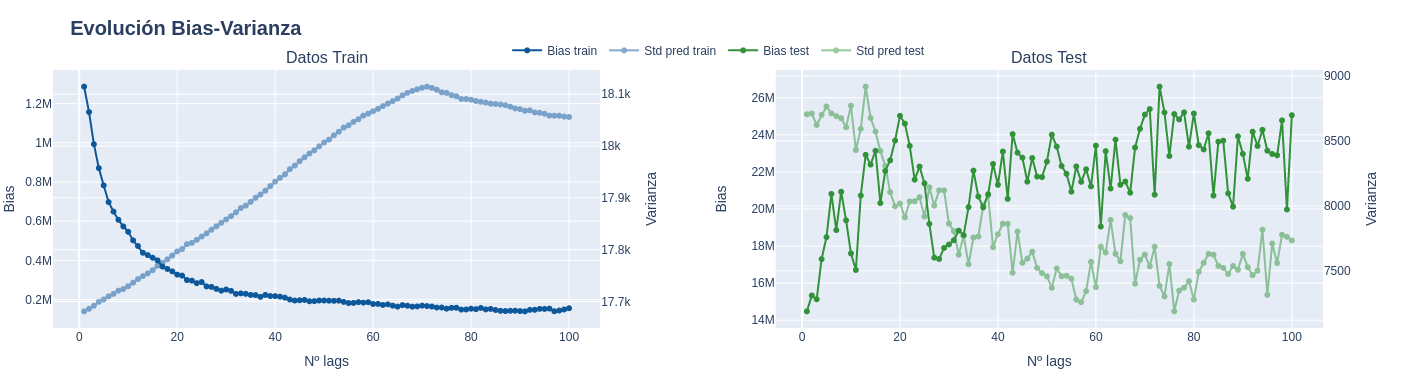

In [31]:
# Gráfico Bias-Varianza
# ==============================================================================
fig = make_subplots(rows=1, cols=2, horizontal_spacing = 0.13,
                    subplot_titles=("Datos Train", "Datos Test"),
                    specs=[[{"secondary_y": True}, {"secondary_y": True}]])

labels = ['Bias train', 'Std pred train', 'Bias test', 'Std pred test']
plots = [metricas_train, stds_train, metricas_test, stds_test]
secondarys = [False, True, False, True]
colores = [palette_btc['azul'], palette_btc['azul'], palette_btc['verde'], palette_btc['verde']]
opacidades = [1, 0.5, 1, 0.5]
cols = [1, 1, 2, 2]

for label, plot, secondary, color, opacidad, col in zip(labels, plots, secondarys, colores, opacidades, cols):
    
    # Se añanden todas las lineas con un ciclo
    fig.add_trace(
        go.Scatter(x=lags, y=plot, name=f'{label}', mode='lines+markers',
                   opacity=opacidad, line=dict(color=color)),
                   secondary_y=secondary, row=1, col=col
        )
    
fig.update_layout(
    width       = 1200,
    height      = 370,
    title       = dict(text='<b>Evolución Bias-Varianza</b>', font=dict(size=20)),
    legend      = dict(orientation="h", yanchor="bottom",
                       y=1.02, xanchor="right", x=0.65),
    margin      = dict(l=0, r=0, t=70, b=40),
)
fig.update_xaxes(title_text='Nº lags')
fig.update_yaxes(title_text='Bias', secondary_y=False)
fig.update_yaxes(title_text='Varianza', secondary_y=True)
fig.show();

Un buen balance entre bias y varianza minimiza el error total del modelo generado o, dicho de otro modo, a la hora de predecir nuevos datos el modelo es capaz de generalizar lo aprendido en las observaciones de entrenamiento. Según aumenta la complejidad del modelo, es de esperar que el bias se reduzca y la varianza aumente ([*Tradeoff* Bias-Varianza](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)).

Aunque en los datos de entrenamiento se puede observar una curva tipo, los **datos de test** (los cuales reflejan cómo de bien generaliza el modelo) muestran una ausencia de aprendizaje del comportamiento pasado, independientemente del número de *lags* utilizado. Además, esto indica que no merece la pena invertir tiempo en la optimización de lags e hiperparámetros.

## Forecaster con variables exógenas
<br>

Además de utilizar predictores autorregresivos generados a partir del pasado de la propia variable respuesta, es posible añadir otras variables exógenas, **cuyo valor a futuro se conoce**, con el fin de mejorar la predicción. Algunos ejemplos típicos son:

+ Festivos (local, nacional...)

+ Mes del año

+ Día de la semana

+ Hora del día

Para este caso, se decide utilizar las variables resultantes del apartado sobre el halving del Bitcoin y, tras el estudio de la estacionalidad, el mes del año.

In [32]:
# Selección fechas train-test
# ==============================================================================
inicio_train = '2020-01-01 00:00:00'
fin_train = '2021-06-30 23:59:59'

print(f"Serie temporal completa : {data.index.min()} --- {data.index.max()}")
print(f"Fechas train            : {data.loc[inicio_train:fin_train].index.min()} --- {data.loc[inicio_train:fin_train].index.max()}")
print(f"Fechas test             : {data.loc[fin_train:].index.min()} --- {data.loc[fin_train:].index.max()}")

Serie temporal completa : 2013-04-28 00:00:00 --- 2022-01-01 00:00:00
Fechas train            : 2020-01-01 00:00:00 --- 2021-06-30 00:00:00
Fechas test             : 2021-07-01 00:00:00 --- 2022-01-01 00:00:00


Las variables `reward` y `mes`, aunque codificadas como números, son categóricas, por lo que conviene cambiar el tipo con el que están almacenadas.

Dado que estas variables no tienen muchos niveles se recurre a la estrategia de [*One Hot Encoding*](https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html#Binarizaci%C3%B3n-de-las-variables-cualitativas) para incorporarlas al modelo.

In [33]:
# Cambio de las variables categóricas a tipo category
# ==============================================================================
data['mes'] = data.index.month
data['mes']   = data['mes'].astype('category')
data['reward'] = data['reward'].astype('category')

# One hot encoding
data = pd.get_dummies(data, columns=['reward', 'mes'])

data.head(2)

open       close        high         low  change_pct  \
date                                                                     
2013-04-28  135.300003  134.210007  135.979996  132.100006   -0.805614   
2013-04-29  134.444000  144.539993  147.488007  134.000000    7.509441   

            countdown_halving  dia_mes  dia_semana  reward_6.25  reward_12.5  \
date                                                                           
2013-04-28             1168.0       28           7            0            0   
2013-04-29             1167.0       29           1            0            0   

            ...  mes_3  mes_4  mes_5  mes_6  mes_7  mes_8  mes_9  mes_10  \
date        ...                                                            
2013-04-28  ...      0      1      0      0      0      0      0       0   
2013-04-29  ...      0      1      0      0      0      0      0       0   

            mes_11  mes_12  
date                        
2013-04-28       0       0  
2013-04-29       0       0  

[2 rows x 23 columns]

In [34]:
# Se seleccionan todas las variables exógenas, incluidas las obtenidas al hacer
# el one hot encoding.
# ==============================================================================
variables_exogenas = [column for column in data.columns
                      if column.startswith(('reward', 'mes'))]
variables_exogenas.extend(['countdown_halving'])
print(variables_exogenas)

['reward_6.25', 'reward_12.5', 'reward_25.0', 'mes_1', 'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6', 'mes_7', 'mes_8', 'mes_9', 'mes_10', 'mes_11', 'mes_12', 'countdown_halving']


In [48]:
# Función crear, entrenar y testear forecaster con variables exógenas
# ==============================================================================
def producir_predicciones_forecaster_exog(modelo, lags, variable, exog):
    
    # Crear y entrenar forecaster
    forecaster = ForecasterAutoreg(
                    regressor = modelo,
                    lags      = lags
                 )

    forecaster.fit(y    = data.loc[inicio_train:fin_train, variable],
                   exog = data.loc[inicio_train:fin_train, exog])

    # Backtest training data
    metrica_train, predicciones_train = backtesting_forecaster(
                                            forecaster = forecaster,
                                            y          = data.loc[inicio_train:fin_train, variable],
                                            exog       = data.loc[inicio_train:fin_train, exog],
                                            initial_train_size = None,
                                            steps      = 1,
                                            refit      = False,
                                            metric     = 'mean_squared_error',
                                            verbose    = False
                                        )    
    # Backtest test data, refit = False
    metrica_test, predicciones_test = backtesting_forecaster(
                                         forecaster = forecaster,
                                         y          = data.loc[inicio_train:, variable],
                                         exog       = data.loc[inicio_train:, exog],
                                         initial_train_size = len(data.loc[inicio_train:fin_train, variable]),
                                         steps      = 7,
                                         refit      = False,
                                         metric     = 'mean_squared_error',
                                         verbose    = False
                                      )
    
    return metrica_train, metrica_test, predicciones_train, predicciones_test

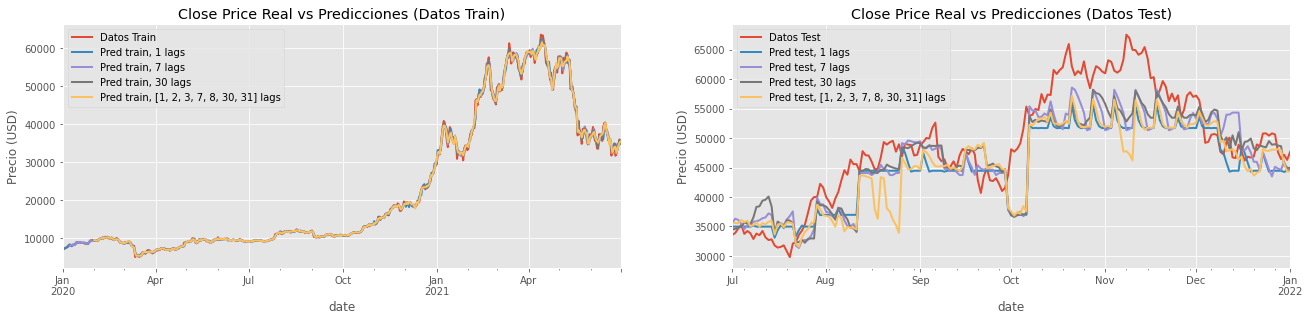

In [57]:
# Gráfico
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 4.5))
axes = axes.flat
data.loc[inicio_train:fin_train, 'close'].plot(ax=axes[0], linewidth=2, label='Datos Train')
data.loc[fin_train:, 'close'].plot(ax=axes[1], linewidth=2, label='Datos Test')

# Entrenar y plot modelo con diferentes lags
# ==============================================================================
lags = [1, 7, 30, [1, 2, 3, 7, 8, 30, 31]]
metricas_train = []
metricas_test = []

for lag in lags:

    metrica_train, metrica_test, predicciones_train, \
    predicciones_test = producir_predicciones_forecaster_exog(
                            LGBMRegressor(random_state=123), 
                            lag, 'close', variables_exogenas
                            )
    
    metricas_train.append(float(metrica_train**0.5))
    metricas_test.append(float(metrica_test**0.5))
    
    # Plot predicciones_train
    predicciones_train.rename(columns={'pred': f'Pred train, {lag} lags'}, inplace=True)
    predicciones_train.tail(len(data['close'])).plot(linewidth=2, ax=axes[0])
    
    # Plot predicciones_test
    predicciones_test.rename(columns={'pred': f'Pred test, {lag} lags'}, inplace=True)
    predicciones_test.plot(linewidth=2, ax=axes[1])

axes[0].set_title('Close Price Real vs Predicciones (Datos Train)')
axes[1].set_title('Close Price Real vs Predicciones (Datos Test)')
for ax in axes:
    ax.set_ylabel('Precio (USD)')
    ax.legend();
    
df_errores = pd.concat([df_errores, pd.DataFrame({'lags': lags, 
                                         'error_train': metricas_train,
                                         'error_test': metricas_test, 
                                         'Exog': True
                                        })
                       ])

In [52]:
# Caclular metricas del modelo según aumenta el número de lags
# ==============================================================================
lags = [x+1 for x in range(100)]
metricas_train = []
stds_train = []
metricas_test = []
stds_test = []

for lag in tqdm(lags):
    metrica_train, metrica_test, predicciones_train \
    , predicciones_test = producir_predicciones_forecaster_exog(
                            LGBMRegressor(random_state=123), 
                            lag, 'close', variables_exogenas)
    
    metricas_train.append(float(metrica_train))
    metricas_test.append(float(metrica_test))
    stds_train.append(predicciones_train.pred.std())
    stds_test.append(predicciones_test.pred.std())

100%|█████████████████████████████████████████| 100/100 [03:05<00:00,  1.86s/it]


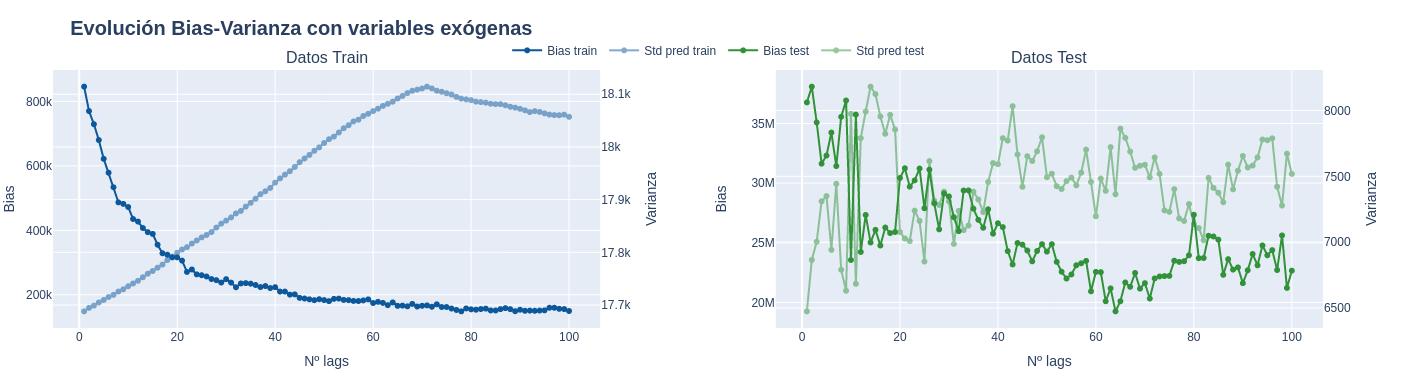

In [54]:
# Gráfico Bias-Varianza
# ==============================================================================
fig = make_subplots(rows=1, cols=2, horizontal_spacing = 0.13,
                    subplot_titles=("Datos Train", "Datos Test"),
                    specs=[[{"secondary_y": True}, {"secondary_y": True}]])

labels = ['Bias train', 'Std pred train', 'Bias test', 'Std pred test']
plots = [metricas_train, stds_train, metricas_test, stds_test]
secondarys = [False, True, False, True]
colores = [palette_btc['azul'], palette_btc['azul'], palette_btc['verde'], palette_btc['verde']]
opacidades = [1, 0.5, 1, 0.5]
cols = [1, 1, 2, 2]

for label, plot, secondary, color, opacidad, col in zip(labels, plots, secondarys, colores, opacidades, cols):
    
    # Se añanden todas las lineas con un ciclo
    fig.add_trace(
        go.Scatter(x=lags, y=plot, name=f'{label}', mode='lines+markers',
                   opacity=opacidad, line=dict(color=color)),
                   secondary_y=secondary, row=1, col=col
        )
    
fig.update_layout(
    width       = 1200,
    height      = 370,
    title       = dict(text='<b>Evolución Bias-Varianza con variables exógenas</b>',
                       font=dict(size=20)),
    legend      = dict(orientation="h", yanchor="bottom",
                       y=1.02, xanchor="right", x=0.65),
    margin      = dict(l=0, r=0, t=70, b=40),
)
fig.update_xaxes(title_text='Nº lags')
fig.update_yaxes(title_text='Bias', secondary_y=False)
fig.update_yaxes(title_text='Varianza', secondary_y=True)
fig.show();

In [60]:
display(df_errores)

lags  error_train   error_test   Exog
0                        1  1134.352886  3804.964664  False
1                        7   804.292828  4303.978072  False
2                       30   494.646312  4389.836613  False
3  [1, 2, 3, 7, 8, 30, 31]   783.383173  4267.720363  False
0                        1   919.699954  6063.587130   True
1                        7   730.516233  5605.933432   True
2                       30   498.404216  5373.981987   True
3  [1, 2, 3, 7, 8, 30, 31]   716.995091  6529.551949   True

En este caso, las variables exógenas seleccionadas no aumentan la capacidad predictiva del modelo.

## Conclusión
<br>

+ Como se ha demostrado en este documento, el precio del Bitcoin no tiene capacidad autorregresiva, la mejor estimación para el valor $t_{n+1}$ será el valor $t_{n}$ más un cambio impredecible. La identificación temprana de la ausencia de esta capacidad mediante análisis descriptivo evita invertir tiempo en la selección y ajuste, de hiperparámetros (*tuning*), del modelo .

+ Cuando se dispone de una serie temporal con ausencia de capacidad autorregresiva se deben buscar variables exógenas capaces de ayudar en el problema. Por ejemplo, si se intentase predecir el precio del Bitcoin a corto plazo (horas) podrían emplearse como variables exógenas: el sentimiento del mercado mediante el análisis de tweets, impacto de los denominados *key opinion leaders*, análisis de noticias más relevantes.

+ Utilizar modelos de machine learning en problemas de *forecasting* es muy sencillo gracias a las funcionalidades ofrecidas por [**Skforecast**](https://joaquinamatrodrigo.github.io/skforecast/latest/index.html).
<br><br>

## Información de sesión

In [61]:
import session_info
session_info.show(html=False)

-----
cryptocmd           0.6.0
lightgbm            3.3.1
matplotlib          3.5.1
numpy               1.22.0
pandas              1.3.5
plotly              5.5.0
scipy               1.7.3
seaborn             0.11.2
session_info        1.0.0
skforecast          0.4.2
sklearn             1.0.2
statsmodels         0.13.1
tqdm                4.62.3
-----
IPython             7.29.0
jupyter_client      7.1.0
jupyter_core        4.9.1
jupyterlab          3.2.5
notebook            6.4.6
-----
Python 3.8.0 (default, Nov  6 2019, 21:49:08) [GCC 7.3.0]
Linux-5.13.0-28-generic-x86_64-with-glibc2.10
-----
Session information updated at 2022-02-08 14:42


**¿Cómo citar este documento?**

<p style="text-align:left"><font size="3" color="#555">
Predicción (forecasting) del precio de Bitcoin con Python by Javier Escobar Ortiz, available under a Attribution 4.0 International (CC BY 4.0) at 
    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by Javier Escobar Ortiz is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

# Generación Gif

**Gif articulo BTC**

In [54]:
repeat_it = 0

if repeat_it == 1:
    import gif
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('ggplot')
    import pandas as pd
    import datetime
    from tqdm import tqdm
    import warnings
    warnings.filterwarnings('ignore')
    
    palette_btc = {'naranja': '#f7931a',
                   'blanco' : '#ffffff',
                   'gris' : '#4d4d4d',
                   'azul' : '#0d579b',
                   'verde' : '#329239'
                  }
    
    # Crear listas con inicio y fin de los cuadrados de train y test
    data.index.name = 'fecha' # Español
    data['Precio'] = data['close'] # Español
    
    steps = len(data)
    step_size = 100 # Tamaño set test
    
    train_start = 0
    train_end = 600 # Tamaño set train
    test_end = train_end + step_size
    lista_train_start = [train_start]
    lista_train_end = [train_end]
    lista_test_end = [test_end]

    for i in range(steps):

        if test_end > steps - step_size:
            train_start += step_size
            train_end += step_size
            test_end = steps-1

            lista_train_start.append(train_start)
            lista_train_end.append(train_end)
            lista_test_end.append(test_end)

            break
        else:
            train_start += step_size
            train_end += step_size
            test_end += step_size

            lista_train_start.append(train_start)
            lista_train_end.append(train_end)
            lista_test_end.append(test_end)
    
    # Ampliar unos meses con df vacío para mejor visualización
    ampliar = 1
    if ampliar == 1:
        
        meses_ampliar = 2 # Seleccionar cuantos meses
        
        last_date = data.index[-1]
        end = data.index[-1] + datetime.timedelta(days=meses_ampliar*30)
        index = pd.date_range(last_date, end=end, freq='D')
        columns = data.columns
        df_plot = pd.DataFrame(index=index, columns=columns)
        df_plot = pd.concat([data, df_plot])
    else:
        df_plot = data.copy()
    
    @gif.frame
    def custom_plot(df_plot, start_train, end_train, end_test):
               
        min_y = df_plot['Precio'].min()
        max_y = df_plot['Precio'].max()
        train = (df_plot.index[start_train], df_plot.index[end_train])
        test = (df_plot.index[end_train], df_plot.index[end_test])  
        
        xlabels = [""] 
        for year in df_plot.index.year.unique():
            xlabels.append(year)

        fig, ax = plt.subplots(figsize=(10, 3.5))
        df_plot['Precio'].plot(ax=ax, color=palette_btc['naranja'])
        ax.fill_between(train, min_y, max_y, facecolor=palette_btc['verde'], alpha=0.4, zorder=0, label='Entrenamiento')
        ax.fill_between(test, min_y, max_y, facecolor=palette_btc['azul'], alpha=0.4, zorder=0, label='Test')
        ax.set_xticklabels(xlabels, rotation=45, ha='center')
        ax.set_ylabel('Precio (USD)')
        ax.set_title('Bitcoin/USD Chart')
        ax.legend()
        ax.grid(alpha=0.6);

        return(ax)
    
    frames = []
    for i in tqdm(range(len(lista_train_start))):
        start_train = lista_train_start[i]
        end_train = lista_train_end[i]
        end_test = lista_test_end[i]
        frame = custom_plot(df_plot, start_train, end_train, end_test)
        frames.append(frame)

    gif.save(frames, './images/btc_train_test.gif', duration=10, unit='s', between='startend')

**GIF backtesting refit True/False**

In [55]:
repeat_it = 0
refit = False
ampliar = True # Ampliar unos meses con df vacío para mejor visualización
meses_ampliar = 1
train_start = 0
train_end = 96 # Tamaño set train
step_size = 10 # Tamaño set test
duracion_gif = 8 # Segundos


if repeat_it == 1:
    import gif
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('ggplot')
    import pandas as pd
    import datetime
    from tqdm import tqdm
    import warnings
    warnings.filterwarnings('ignore')
    
    palette_btc = {'naranja': '#f7931a',
                   'blanco' : '#ffffff',
                   'gris' : '#4d4d4d',
                   'azul' : '#0d579b',
                   'verde' : '#329239'
                  }
    
    # Download data
    # ==============================================================================
    url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
    data_gif = pd.read_csv(url, sep=',')

    # Data preprocessing
    # ==============================================================================
    data_gif['date'] = pd.to_datetime(data_gif['fecha'], format='%Y/%m/%d')
    data_gif = data_gif.set_index('date')
    data_gif = data_gif.rename(columns={'x': 'y'})
    data_gif = data_gif.asfreq('MS')
    data_gif = data_gif['y']
    data_gif = data_gif.sort_index()

    steps = len(data_gif)

    test_start = train_end
    test_end = train_end + step_size
    lista_train_start = [train_start]
    lista_train_end = [train_end]
    lista_test_start = [test_start]
    lista_test_end = [test_end]

    for i in range(steps):

        if test_end > steps - step_size:
            
            if refit:
                train_end += step_size
                test_start += step_size
                test_end = steps-1
            else:
                test_start += step_size
                test_end = steps-1
            
            lista_train_start.append(train_start)
            lista_train_end.append(train_end)
            lista_test_start.append(test_start)
            lista_test_end.append(test_end)

            break
        else:
            if refit:
                train_end += step_size
                test_start += step_size
                test_end += step_size
            else:
                test_start += step_size
                test_end += step_size
                
            lista_train_start.append(train_start)
            lista_train_end.append(train_end)
            lista_test_start.append(test_start)
            lista_test_end.append(test_end)
        
    #  Ampliar unos meses con df vacío para mejor visualización
    if ampliar:
        last_date = data_gif.index[-1]
        end = data_gif.index[-1] + datetime.timedelta(days=meses_ampliar*30)
        index = pd.date_range(last_date, end=end, freq='D')
        df_plot = pd.DataFrame(index=index)
        df_plot = pd.concat([data_gif, df_plot])
    else:
        df_plot = data_gif.copy()
    
    df_plot['y'] = df_plot[0]
    
    @gif.frame
    def custom_plot(df_plot, start_train, end_train, start_test, end_test):
               
        min_y = df_plot['y'].min()
        max_y = df_plot['y'].max()
        train = (df_plot.index[start_train], df_plot.index[end_train])
        test = (df_plot.index[start_test], df_plot.index[end_test])  
        
        xlabels = [""] 
        for year in df_plot.index.year.unique():
            xlabels.append(year)
        
        # Plot
        # ==============================================================================
        fig, ax=plt.subplots(figsize=(9, 4))
        df_plot['y'].plot(ax=ax)
        ax.fill_between(train, min_y, max_y, facecolor=palette_btc['verde'], alpha=0.4, zorder=0, label='Train')
        ax.fill_between(test, min_y, max_y, facecolor=palette_btc['azul'], alpha=0.4, zorder=0, label='Test')
        ax.set_xticklabels(xlabels, rotation=45, ha='center')
        ax.legend()
        if refit:
            ax.set_title('Timeseries backtesting with refit')
        else:
            ax.set_title('Timeseries backtesting without refit')
            
        return(ax)
    
    frames = []
    for i in tqdm(range(len(lista_train_start))):
        start_train = lista_train_start[i]
        end_train = lista_train_end[i]
        start_test = lista_test_start[i]
        end_test = lista_test_end[i]
        frame = custom_plot(df_plot, start_train, end_train, start_test, end_test)
        frames.append(frame)
    
    
    if refit:
        gif.save(frames, './images/backtesting_refit.gif', duration=duracion_gif, unit='s', between='startend')
    else:
        gif.save(frames, './images/backtesting_no_refit.gif', duration=duracion_gif, unit='s', between='startend')